In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import sklearn

In [2]:
%store -r cook_county_gdf
%store -r CC_nodeaths

In [5]:
columns_to_keep = ['STATEFP', 'COUNTYFP', 'TRACTCE','NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry']

gdf_annual = cook_county_gdf.groupby(['GEOID', 'year']).size().reset_index(name='deaths')

In [8]:
gdf_annual

,GEOID,year,deaths
0,17031010100,2014,1
1,17031010100,2015,1
2,17031010100,2016,3
3,17031010100,2017,2
4,17031010100,2019,2
...,...,...,...
5759,17031980000,2021,1
5760,17031980000,2022,3
5761,17031980000,2023,4
5762,17031980100,2018,1


In [7]:
gdf_annual['GEOID'].nunique() #missing 58 tracts

1274

### Adding rows for zero-death tracts & years

df_annnual does not include rows for census tracts or years that have zero deaths. the below code finds the missing census tracts and years and creates a row for it in the dataframe. 

In [12]:
##below chunk of code adds in any tracts that had 0 deaths over the course of 2014-2023, and adds the tract into df

for index, row in CC_nodeaths.iterrows():
    tract_geoID = row['GEOID']

    for year in range(2014, 2024):
        # Check if the row already exists 
        existing_row = df_annual[(df_annual['tract_geoID'] == tract_geoID) & (df_annual['year'] == year)]

    if existing_row.empty:
            new_row = pd.DataFrame([[tract_geoID, year, 0]], columns=df_annual.columns)
            df_annual = pd.concat([df_annual, new_row], ignore_index=True)


In [13]:
df_annual['tract_geoID'].nunique() #yay - this matches the # of tracts in the shapefile from census. 

1332

In [15]:
##below chunk of code goes through all tracts and ensures it has a row for each year b/t 2014-2023, if not,
## we add the year and set the number of deaths equal to 0

years = range(2014, 2024)
updated_rows = []

for tract_geoID in df_annual['tract_geoID'].unique():
    existing_years = set(df_annual[df_annual['tract_geoID'] == tract_geoID]['year'])
    missing_years = set(years) - existing_years
    
    for year in missing_years:
        updated_rows.append({'tract_geoID': tract_geoID, 'year': year, 'deaths_sum': 0})

df_annual = pd.concat([df_annual, pd.DataFrame(updated_rows)], ignore_index=True)


## Tables & Graphs

In [16]:
sparsity_df = pd.DataFrame(columns=['year', 'Total Deaths', 'Sparsity Rate'])

years = range(2014, 2023)
for year in years:
    year_df = df_annual[df_annual['year'] == year]
    zero_deaths_count = year_df[year_df['deaths_sum'] == 0].shape[0]
    total_count = year_df.shape[0]
    sparsity_rate = (zero_deaths_count / total_count) * 100
    total_deaths = year_df['deaths_sum'].sum()
    sparsity_df = pd.concat([sparsity_df, pd.DataFrame({'year': [year], 'Total Deaths': [total_deaths], 'Sparsity Rate': [sparsity_rate]})], ignore_index=True)


raw_sparsity = sparsity_df['Sparsity Rate']
sparsity_df['Sparsity Rate'] = sparsity_df['Sparsity Rate'].round(3).astype(str) + '%'
print(sparsity_df)

   year Total Deaths Sparsity Rate
0  2014          209       86.036%
1  2015          616       67.342%
2  2016         1029       53.754%
3  2017         1109       53.303%
4  2018         1078       54.429%
5  2019         1210       52.102%
6  2020         1687       43.619%
7  2021         1790       43.168%
8  2022         1848       43.018%


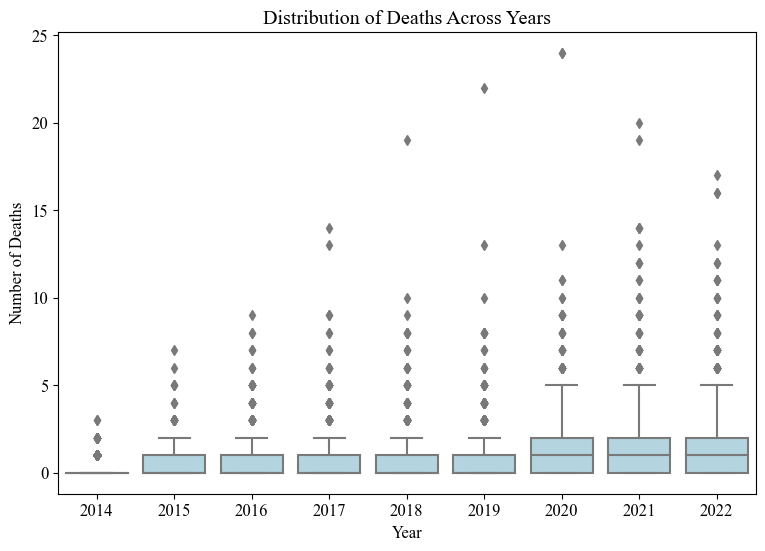

In [28]:
plt.figure(figsize=(9, 6))
df_no23 = df_annual[df_annual['year'] != 2023]
sns.boxplot(x='year', y='deaths_sum', data=df_no23, color='lightblue')

plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.title('Distribution of Deaths Across Years')

ax.set_xticklabels([year for year in df_annual['year'].unique() if year != 2023])

ax.set_xlabel('Year')
plt.show()


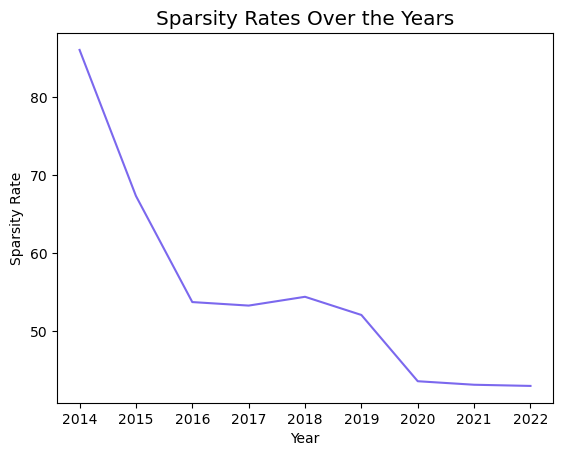

In [18]:
plt.plot(range(2014, 2023), raw_sparsity, color='mediumslateblue')

font = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)


plt.xlabel('Year')
plt.ylabel('Sparsity Rate')
plt.title('Sparsity Rates Over the Years')
plt.grid(False)

plt.show()